In [1]:
from __future__ import print_function
    
import time
import sys
import random
import datetime
from datetime import date
from typing import NamedTuple, Dict
from dataclasses import dataclass
from recordclass import RecordClass, dataobject
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass



def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = sys.getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = sys.getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o), file=sys.stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)


##### NamedTuple #####
class PricesNamedTuple(NamedTuple("Prices", 
                         [('open', float), 
                          ('high', float), 
                          ('low', float), 
                          ('close', float)])):
    pass

class TradeDayNamedTuple(NamedTuple("TradeDay", 
                          (("symbol", str), 
                           ("dt", date), 
                           ("prices", PricesNamedTuple)))):

    def return_change(self):
        return round((self.prices.close - self.prices.open) / self.prices.open, 4)

    def update_symbol(self, symb):
        self = self._replace(symbol = symb)



##### DataClass #####
@dataclass
class PricesDataClass: 
    open: float
    high: float
    low: float
    close: float

@dataclass
class TradeDayDataClass:
    symbol: str
    dt: date
    prices: PricesDataClass

    def return_change(self):
        return round((self.prices.close - self.prices.open) / self.prices.open, 4)

    def update_symbol(self, symb):
        self.symbol = symb


##### RecordClass #####        
class PricesRecordClass(RecordClass):
    open: float
    high: float
    low: float
    close: float

class TradeDayRecordClass(RecordClass):
    symbol: str
    dt: date
    prices: PricesRecordClass

    def return_change(self):
        return round((self.prices.close - self.prices.open) / self.prices.open, 4)

    def update_symbol(self, symb):
        self.symbol = symb

##### dataobject #####        
class PricesDataobject(dataobject, fast_new=True):
    open: float
    high: float
    low: float
    close: float

class TradeDayDataobject(dataobject, fast_new=True):
    symbol: str
    dt: date
    prices: PricesDataobject

    def return_change(self):
        return round((self.prices.close - self.prices.open) / self.prices.open, 4)

    def update_symbol(self, symb):
        self.symbol = symb
        

##### Regular Python class #####
class PricesClass():
    open: float
    high: float
    low: float
    close: float

    def __init__(self, _open, _high, _low, _close):
        self.open = _open
        self.high = _high
        self.low = _low
        self.close = _close

class TradeDayClass():
    symbol: str
    dt: date
    prices: PricesRecordClass

    def __init__(self, _symbol, _dt, _prices):
        self.symbol = _symbol
        self.dt = _dt
        self.prices = _prices

    def return_change(self):
        return round((self.prices.close - self.prices.open) / self.prices.open, 4)

    def update_symbol(self, symb):
        self.symbol = symb


##### Regular Python class with slots #####
class PricesClassSlots():
    __slots__ = ['open', 'high', 'low', 'close']
    open: float
    high: float
    low: float
    close: float

    def __init__(self, _open, _high, _low, _close):
        self.open = _open
        self.high = _high
        self.low = _low
        self.close = _close

class TradeDayClassSlots():
    __slots__ = ['symbol', 'dt', 'prices']
    symbol: str
    dt: date
    prices: PricesRecordClass

    def __init__(self, _symbol, _dt, _prices):
        self.symbol = _symbol
        self.dt = _dt
        self.prices = _prices

    def return_change(self):
        return round((self.prices.close - self.prices.open) / self.prices.open, 4)

    def update_symbol(self, symb):
        self.symbol = symb


##### Python dict #####
def PricesDict(_open, _high, _low, _close):
    return {"open": _open, "high": _high, "low": _low, "close": _close}


def TradeDayDict(symbol, dt, prices):
    return {"symbol": symbol, "dt": dt, "prices": prices}



stats = {}
def run_test(objType):
    import gc
    gc.collect()
    tstats = stats[objType] = {}
    print("====== %s Performance Report ======" % objType)
    print("Time it takes to create 'day' object is: ")
    TradeDay = eval("TradeDay%s" % objType)
    Prices = eval("Prices%s" % objType)
    data: Dict[str, TradeDay] = {}
    # data = sorteddict()
    obj_count = 100000
#     stats['obj_count'] = obj_count

    st = time.time()
    for i in range(0, obj_count):
        data[str(i)] = TradeDay("MA", datetime.date.today(), Prices(random.random(), 30.0, 5.0, 20.0))
    print("%s day %s created     at: %8s per second" % (obj_count, objType, int(obj_count / (time.time() - st))))
    tstats['created'] = int(obj_count / (time.time() - st))

    st = time.time()
    if objType == 'Dict':
        for k, v in data.items():
            d = v['prices']
    else:
        for k, v in data.items():
            d = v.prices
    print("%s day %s top-read    at: %8s per second" % (obj_count, objType, int(obj_count / (time.time() - st))))
    tstats['top_read'] = int(obj_count / (time.time() - st))

    st = time.time()
    for k, v in data.items():
        if objType == 'Dict':
            d = v['prices']['open']
        else:
            d = v.prices.open
    print("%s day %s sub-read    at: %8s per second" % (obj_count, objType, int(obj_count / (time.time() - st))))
    tstats['sub_read'] = int(obj_count / (time.time() - st))

    st = time.time()
    for k, v in data.items():
        if objType == 'Dict':
            d = round((v['prices']['close'] - v['prices']['open']) / v['prices']['open'], 4)
        else:
            d = round((v.prices.close - v.prices.open) / v.prices.open, 4)
    print("%s day %s change      at: %8s per second" % (obj_count, objType, int(obj_count / (time.time() - st))))
    tstats['change'] = int(obj_count / (time.time() - st))

    st = time.time()
    for k, v in data.items():
        if objType == 'Dict':
            v['symbol'] = "AAA"
        elif objType == 'NamedTuple':
            v = v._replace(symbol="AAA")
        else:
            v.symbol = "AAA"
    print("%s day %s mutate      at: %8s per second" % (obj_count, objType, int(obj_count / (time.time() - st))))
    tstats['mutate'] = int(obj_count / (time.time() - st))

    st = time.time()
    for k, v in data.items():
        if objType == 'Dict':
            d = round((v['prices']['close'] - v['prices']['open']) / v['prices']['open'], 4)
        else:
            d = v.return_change()
    print("%s day %s class_read      at: %8s per second" % (obj_count, objType, int(obj_count / (time.time() - st))))
    tstats['class_read'] = int(obj_count / (time.time() - st))

    st = time.time()
    for k, v in data.items():
        if objType == 'Dict':
            v['symbol'] = "AAA"
        else:
            v.update_symbol("AAA")
    print("%s day %s class_update      at: %8s per second" % (obj_count, objType, int(obj_count / (time.time() - st))))
    tstats['class_update'] = int(obj_count / (time.time() - st))

    print("The size of single {}:{}: bytes".format(objType, int(total_size(data) / obj_count)))

if __name__ == '__main__':
    run_test('Dict')
    run_test('Class')
    run_test('ClassSlots')
    run_test('DataClass')
    run_test('RecordClass')
    run_test('Dataobject')
    run_test('NamedTuple')
    

====== Dict Performance Report ======
Time it takes to create 'day' object is: 
100000 day Dict created     at:   270904 per second
100000 day Dict top-read    at:  8549858 per second
100000 day Dict sub-read    at:  7305368 per second
100000 day Dict change      at:  1774885 per second
100000 day Dict mutate      at: 10659780 per second
100000 day Dict class_read      at:  1925078 per second
100000 day Dict class_update      at: 10850611 per second
The size of single Dict:626: bytes
====== Class Performance Report ======
Time it takes to create 'day' object is: 
100000 day Class created     at:   210074 per second
100000 day Class top-read    at: 10240750 per second
100000 day Class sub-read    at:  7526250 per second
100000 day Class change      at:  1686525 per second
100000 day Class mutate      at:  8782779 per second
100000 day Class class_read      at:  1809582 per second
100000 day Class class_update      at:  6950310 per second
The size of single Class:154: bytes
====== ClassS

In [2]:
import matplotlib.pyplot as plt

[270825, 210032, 332360, 213697, 586690, 693234, 280490]
[8488260, 10184799, 14222318, 12518815, 22110195, 22249769, 14832917]
[7272182, 7502958, 8600877, 7932039, 12389389, 12369294, 9776248]
[1773595, 1685583, 1824657, 1727344, 2093686, 2091650, 1895165]
[10630063, 8764243, 5845393, 9176301, 8629900, 10847524, 1380032]
[1923930, 1808731, 1730045, 1863323, 1866208, 1810324, 1866549]
[10815636, 6939042, 4906307, 7268149, 8346043, 8095236, 1249007]


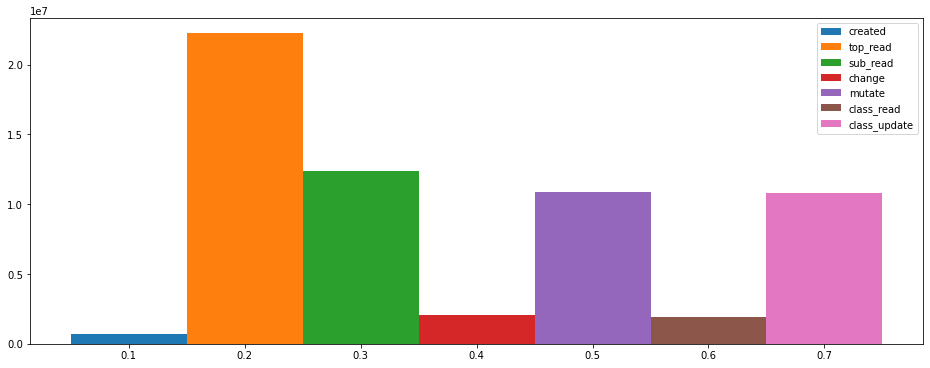

In [3]:
plt.figure(figsize=(16,6))
i = 1
for kind in ('created', 'top_read', 'sub_read', 'change', 'mutate', 'class_read', 'class_update'):
    vals = [d[kind] for t,d in stats.items()]
    print(vals)
    plt.bar(0.1*i, vals, 0.1, label=kind)
    i += 1
plt.legend()
plt.show()

In [4]:
import pandas as pd

In [5]:
df = pd.DataFrame(stats)

In [6]:
df

,Dict,Class,ClassSlots,DataClass,RecordClass,Dataobject,NamedTuple
created,270825,210032,332360,213697,586690,693234,280490
top_read,8488260,10184799,14222318,12518815,22110195,22249769,14832917
sub_read,7272182,7502958,8600877,7932039,12389389,12369294,9776248
change,1773595,1685583,1824657,1727344,2093686,2091650,1895165
mutate,10630063,8764243,5845393,9176301,8629900,10847524,1380032
class_read,1923930,1808731,1730045,1863323,1866208,1810324,1866549
class_update,10815636,6939042,4906307,7268149,8346043,8095236,1249007


In [7]:
df2 = df.copy()

In [8]:
for i in range(7):
    df2.iloc[i] = round(df2.iloc[i] / max(df2.iloc[i]), 2)

In [9]:
df2

,Dict,Class,ClassSlots,DataClass,RecordClass,Dataobject,NamedTuple
created,0.39,0.30,0.48,0.31,0.85,1.00,0.40
top_read,0.38,0.46,0.64,0.56,0.99,1.00,0.67
sub_read,0.59,0.61,0.69,0.64,1.00,1.00,0.79
change,0.85,0.81,0.87,0.83,1.00,1.00,0.91
mutate,0.98,0.81,0.54,0.85,0.80,1.00,0.13
class_read,1.00,0.94,0.90,0.97,0.97,0.94,0.97
class_update,1.00,0.64,0.45,0.67,0.77,0.75,0.12
